<a href="https://colab.research.google.com/github/AbdulmagedALKHULAIFI/projet7_data_science/blob/main/P7_04_notebook_test_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and import

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
source_path = "/content/drive/MyDrive/OC/Projet 7/source/"
data_path = "/content/drive/MyDrive/OC/Projet 7/data/" 

In [50]:
!pip install sklearn

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import *
import pickle
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import lightgbm as lgb

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format

In [52]:
from P7_01_functions import *
import P7_01_functions
help(P7_01_functions)

Help on module P7_01_functions:

NAME
    P7_01_functions - Fichier contenant les fonctions du P7

FUNCTIONS
    cat_analyzer(dataframe, variable, target=None)
        Categorical Variables & Target
    
    corr_plot(data, remove=['Id'], corr_coef='pearson', figsize=(20, 20))
        Numerical Variables
    
    display_importances(feature_importance_df_)
    
    display_precision_recall(y_, oof_preds_, folds_idx_)
    
    display_roc_curve(y_, oof_preds_, folds_idx_)
    
    grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False)
        Grab Column Names
    
    high_correlation(data, remove=['SK_ID_CURR', 'SK_ID_BUREAU'], corr_coef='pearson', corr_value=0.7)
        Get high correlated variables
    
    missing_values(data, plot=False)
        Missing Value
    
    num_plot(data, num_cols, remove=['Id'], hist_bins=10, figsize=(20, 4))
        Plot numerical variables
    
    one_hot_encoder(df, nan_as_category=True)
        One-hot encoding for categorical columns w

# 1. Préparation application

Création des tables de données à envoyer dans l'application

## Import des tables

In [53]:
data = pd.read_feather(source_path + 'df_complet')
data.sort_values(by=['SK_ID_CURR'], inplace=True)

train = data[data.TARGET.isnull() == False]
test = data[data.TARGET.isnull()]

## Suppression des valeurs manquantes

In [54]:
interpretable_important_data = ['SK_ID_CURR',
                                'PAYMENT_RATE',
                                'AMT_ANNUITY',
                                'DAYS_BIRTH',
                                'DAYS_EMPLOYED',
                                'ANNUITY_INCOME_PERC']

interpretable_important_data_target = ['SK_ID_CURR',
                                       'PAYMENT_RATE',
                                       'AMT_ANNUITY',
                                       'DAYS_BIRTH',
                                       'DAYS_EMPLOYED',
                                       'ANNUITY_INCOME_PERC',
                                       'TARGET']

In [55]:
data[interpretable_important_data].head()

,SK_ID_CURR,PAYMENT_RATE,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,ANNUITY_INCOME_PERC
242257,100001,0.04,"20,560.50",-19241,"-2,329.00",0.15
0,100002,0.06,"24,700.50",-9461,-637.00,0.12
1,100003,0.03,"35,698.50",-16765,"-1,188.00",0.13
242258,100005,0.08,"17,370.00",-18064,"-4,469.00",0.18
2,100008,0.06,"27,517.50",-16941,"-1,588.00",0.28


In [56]:
data[interpretable_important_data].isna().sum()

SK_ID_CURR             0
PAYMENT_RATE           0
AMT_ANNUITY            0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
ANNUITY_INCOME_PERC    0
dtype: int64

In [57]:
# on supprime les lignes avec des valeurs manquantes dans la liste de variables importantes
data.dropna(subset=interpretable_important_data, inplace=True)

In [58]:
data_api = data.iloc[:10000, :]

In [59]:
data_api.shape

(10000, 1124)

In [60]:
data_api.to_csv(source_path + "data_api.csv", index=False)

In [61]:
df_interp = pd.read_csv(source_path + "df_interprete")

In [62]:
#df_interp = pd.read_csv('df_interprete')
#df_interp = df_interp.drop('Unnamed: 0', axis=1)
#df_interp.head()

In [63]:
df_interp.shape

(291568, 8)

In [64]:
df_interp.head(3)

,Unnamed: 0,Identifiant,Durée emprunt,Annuités,Âge,Employé depuis,Annuités/revenus,Défaut paiement
0,0,100002,16.5 ans,24700.5 $,25.9 ans,1.7 ans,12.2 %,Oui
1,1,100003,36.2 ans,35698.5 $,45.9 ans,3.3 ans,13.2 %,Non
2,2,100004,20.0 ans,6750.0 $,52.2 ans,0.6 ans,10.0 %,Non


## Création du modèle des plus proches voisins

In [65]:
from sklearn.neighbors import NearestNeighbors

# définition du modèle des plus proches voisins

df_nn = train[interpretable_important_data]
# on ajoute la cible
df_nn['TARGET'] = train['TARGET']
# on supprime les valeurs manquantes
df_nn.dropna(subset=interpretable_important_data, inplace=True)

#on standardise
std = StandardScaler()
df_std = std.fit_transform(df_nn[interpretable_important_data])
df_std = pd.DataFrame(df_std,
                      index=df_nn.index,
                      columns=[interpretable_important_data])

nn = NearestNeighbors(n_neighbors=6)
nn.fit(df_std)

NearestNeighbors(n_neighbors=6)

In [66]:
df_nn.head(3)

,SK_ID_CURR,PAYMENT_RATE,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,ANNUITY_INCOME_PERC,TARGET
242257,100001,0.04,"20,560.50",-19241,"-2,329.00",0.15,0.08
0,100002,0.06,"24,700.50",-9461,-637.00,0.12,1.00
1,100003,0.03,"35,698.50",-16765,"-1,188.00",0.13,0.00


In [67]:
# client_list = std.transform(data[interpretable_important_data])  # standardisation

# for i in range(len(data)):
#     distance, voisins = nn.kneighbors([client_list[i]])
#     voisins = voisins[0]
#     # on crée un dataframe avec les voisins
#     voisins_table = pd.DataFrame()
#     for v in range(len(voisins)):
#         voisins_table[v] = df_nn.iloc[voisins[v]]
# voisins_table.head()

In [68]:
# voisins_table.to_csv(source_path + "voisins_table.csv", index=False)

In [69]:
voisins_table = pd.read_csv(source_path + "voisins_table.csv")

In [70]:
voisins_table.head(3)

,0,1,2,3,4,5
0,"456,255.00","455,600.00","437,236.00","422,157.00","452,609.00","449,429.00"
1,0.07,0.07,0.07,0.07,0.08,0.07
2,"49,117.50","50,814.00","51,138.00","45,724.50","53,460.00","47,380.50"


## Export des modèles

In [71]:
filename = source_path + 'NearestNeighborsModel.pkl'
outfile = open(filename,'wb')
dump(nn, outfile)
outfile.close()

In [72]:
filename = source_path + 'StandardScaler.pkl'
outfile = open(filename,'wb')
dump(std, outfile)
outfile.close()

In [73]:
filename = source_path + 'df_nn.pkl'
outfile = open(filename,'wb')
dump(df_nn, outfile)
outfile.close()

## Probabilités d'impayés

In [74]:

# import du modèle lgbm entrainé
infile = open(source_path + 'LightGBMModel.pkl', 'rb')
try:
    lgbm = pickle.load(infile)
except UnicodeDecodeError:
   lgbm = pickle.load(infile, fix_imports=True, encoding="latin1")

infile.close()

In [75]:
# results = pd.DataFrame(lgbm.predict_proba(data.drop(['TARGET', 'SK_ID_CURR'], axis=1)),index=data['SK_ID_CURR'])

# results.rename({1: "Probabilité d'impayés"}, axis=1, inplace=True)
# results.drop([0], axis=1, inplace=True)
# results.head()

In [76]:
data[interpretable_important_data_target].to_csv('interpretable_important_data_target')

In [77]:
data[interpretable_important_data_target].head(10)

,SK_ID_CURR,PAYMENT_RATE,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,ANNUITY_INCOME_PERC,TARGET
242257,100001,0.04,"20,560.50",-19241,"-2,329.00",0.15,0.08
0,100002,0.06,"24,700.50",-9461,-637.00,0.12,1.00
1,100003,0.03,"35,698.50",-16765,"-1,188.00",0.13,0.00
242258,100005,0.08,"17,370.00",-18064,"-4,469.00",0.18,0.08
2,100008,0.06,"27,517.50",-16941,"-1,588.00",0.28,0.00
3,100009,0.03,"41,301.00",-13778,"-3,130.00",0.24,0.00
4,100010,0.03,"42,075.00",-18850,-449.00,0.12,0.00
5,100011,0.03,"33,826.50",-20099,"-2,490.74",0.30,0.00
242259,100013,0.11,"69,777.00",-20038,"-4,458.00",0.34,0.08
6,100014,0.03,"21,177.00",-10197,-679.00,0.19,0.00


# API

## unpaid probability

In [78]:
selected_data = data[interpretable_important_data_target]

In [79]:
x = selected_data.drop(['SK_ID_CURR','TARGET'],axis=1)
y = selected_data.TARGET

In [80]:
y.value_counts()

0.00    223235
0.08     42477
1.00     19022
Name: TARGET, dtype: int64

In [81]:
y = y.round(decimals = 0)

In [82]:
from sklearn.model_selection import train_test_split

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)

In [83]:
model = lgb.LGBMClassifier(learning_rate=0.09,is_unbalance=True, max_depth=-5 ,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.544696	training's binary_logloss: 0.544696	valid_0's binary_logloss: 0.547158	valid_0's binary_logloss: 0.547158
[40]	training's binary_logloss: 0.613025	training's binary_logloss: 0.613025	valid_0's binary_logloss: 0.617213	valid_0's binary_logloss: 0.617213
[60]	training's binary_logloss: 0.620161	training's binary_logloss: 0.620161	valid_0's binary_logloss: 0.625595	valid_0's binary_logloss: 0.625595
[80]	training's binary_logloss: 0.617301	training's binary_logloss: 0.617301	valid_0's binary_logloss: 0.623979	valid_0's binary_logloss: 0.623979
[100]	training's binary_logloss: 0.612725	training's binary_logloss: 0.612725	valid_0's binary_logloss: 0.620631	valid_0's binary_logloss: 0.620631


LGBMClassifier(is_unbalance=True, learning_rate=0.09, max_depth=-5,
               random_state=42)

In [84]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.6644
Testing accuracy 0.6552


In [85]:
selected_data.head(5)

,SK_ID_CURR,PAYMENT_RATE,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,ANNUITY_INCOME_PERC,TARGET
242257,100001,0.04,"20,560.50",-19241,"-2,329.00",0.15,0.08
0,100002,0.06,"24,700.50",-9461,-637.00,0.12,1.00
1,100003,0.03,"35,698.50",-16765,"-1,188.00",0.13,0.00
242258,100005,0.08,"17,370.00",-18064,"-4,469.00",0.18,0.08
2,100008,0.06,"27,517.50",-16941,"-1,588.00",0.28,0.00


In [88]:
ynew = model.predict_proba([[0.03,35.700,-17461,-1.188,0.12]])
print(" Impaie probab= %s" % (ynew[0][1]))

 Impaie probab= 0.3421310078988017


In [87]:
ynew = model.predict([[0.03,35.700,-17461,-1.188,0.12]])
print(" Predicted= %s" % (ynew[0]))

 Predicted= 0.0


### Export

In [86]:
proba_model = source_path + 'proba_model.sav'
pickle.dump(model, open(proba_model, 'wb'))

### Import

In [15]:
proba_model = source_path + 'proba_model.sav'
loaded_model = pickle.load(open(proba_model, 'rb'))
# result = loaded_model.score(X_test, Y_test)
ynew = loaded_model.predict([[0.03,35.700,-17461,-1.188,0.12]])
print(" Predicted= %s" % (ynew[0]))

 Predicted= 0.0


#Visualization

## Graphe radar

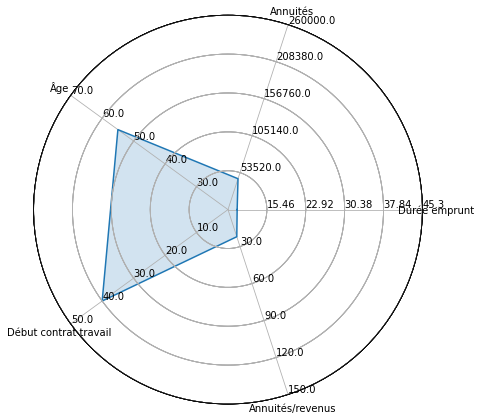

In [ ]:
#https://qastack.fr/datascience/6084/how-do-i-create-a-complex-radar-chart

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

# example data
variables = ("Durée emprunt", "Annuités", "Âge", 
            "Début contrat travail", "Annuités/revenus")
data_ex = (9.76, 45000, 55, 40, 22)
ranges = [(8.0, 45.3), (1900, 260000), (20, 70),
         (0,50), (0, 150)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data_ex)
radar.fill(data_ex, alpha=0.2)
plt.show()    

In [ ]:
def interpretable_sans_unite(df):
    """Fonction qui va rendre les colonnes d'un df interpretables (sans unité)"""
    df_int = pd.DataFrame(index=range(len(df)),
                          columns=['Identifiant',
                                   'Durée emprunt',
                                   'Annuités',
                                   'Âge',
                                   'Début contrat travail',
                                   'Annuités/revenus',
                                   'Défaut paiement'])

    for i in range(len(df)) :
        df_int['Identifiant'].iloc[i] = int(df['SK_ID_CURR'].iloc[i])

        df_int["Durée emprunt"].iloc[i] = np.around(1 / df['PAYMENT_RATE'].iloc[i], decimals=1)

        df_int['Annuités'].iloc[i] = df['AMT_ANNUITY'].iloc[i]

        df_int['Âge'].iloc[i] = np.around(df['DAYS_BIRTH'].iloc[i] / -365, decimals=1)

        df_int['Début contrat travail'].iloc[i] = np.around(df['DAYS_EMPLOYED'].iloc[i] / -365, decimals=1)

        df_int['Annuités/revenus'].iloc[i] = np.around(df['ANNUITY_INCOME_PERC'].iloc[i] * 100, decimals=1)

        if 'TARGET' in df.columns:
            if df['TARGET'].iloc[i] == 1.0:
                df_int['Défaut paiement'].iloc[i] = 'Oui'
            elif df['TARGET'].iloc[i] == 0:
                df_int['Défaut paiement'].iloc[i] = 'Non'
            else:
                df_int['Défaut paiement'].iloc[i] = 'Inconnu'
        else:
            df_int['Défaut paiement'].iloc[i] = 'Inconnu'

    return df_int

In [ ]:
# df_interp_sans_unite = interpretable_sans_unite(data)
# df_interp_sans_unite.drop('Défaut paiement', axis=1, inplace=True)
# df_interp_sans_unite.to_csv(source_path + '/df_interp_sans_unite', index=False)
df_interp_sans_unite = pd.read_csv(source_path + 'df_interp_sans_unite')

df_interp_sans_unite.head()

,Identifiant,Durée emprunt,Annuités,Âge,Début contrat travail,Annuités/revenus
0,100002,16.50,"24,700.50",25.90,1.70,12.20
1,100003,36.20,"35,698.50",45.90,3.30,13.20
2,100004,20.00,"6,750.00",52.20,0.60,10.00
3,100006,10.50,"29,686.50",52.10,8.30,22.00
4,100007,23.50,"21,865.50",54.60,8.30,18.00


In [ ]:
df_interp_sans_unite.describe()

,Identifiant,Durée emprunt,Annuités,Âge,Début contrat travail,Annuités/revenus
count,"291,568.00","291,568.00","291,568.00","291,568.00","291,568.00","291,568.00"
mean,"278,084.80",20.92,"28,175.08",40.45,6.57,17.78
std,"102,876.17",7.80,"14,916.34",10.00,6.40,9.13
min,"100,001.00",8.00,"1,980.00",20.10,0.00,0.00
25%,"188,941.75",14.90,"17,266.50",32.30,2.10,11.30
50%,"278,045.50",20.00,"26,050.50",39.90,4.60,16.10
75%,"367,237.25",26.20,"35,937.00",48.10,8.80,22.50
max,"456,255.00",45.30,"258,025.50",69.00,49.10,151.20


## Création des groupes de clients

In [ ]:
df_group = pd.read_csv(data_path + 'application_train.csv')
test_df = pd.read_csv(data_path + 'application_test.csv')

print("Train samples: {}, test samples: {}".format(len(df_group), len(test_df)))

df_group = df_group.append(test_df)
df_group = df_group[~(df_group.CODE_GENDER.str.contains("XNA"))]
df_group = df_group[~(df_group.ORGANIZATION_TYPE.str.contains("XNA"))]
df_group = df_group[~(df_group.NAME_EDUCATION_TYPE.str.contains("XNA"))]
df_group = reduce_mem_usage(df_group)

Train samples: 307511, test samples: 48744
Memory usage of dataframe is 273.64 MB
Memory usage after optimization is: 58.41 MB
Decreased by 78.7%


### Genre

In [ ]:
genre = df_group[['TARGET', 'CODE_GENDER', 'SK_ID_CURR']]
genre.rename(columns={'SK_ID_CURR':'Identifiant'}, inplace=True)
genre = genre.merge(df_interp_sans_unite,
                    how='right', on='Identifiant').drop('Identifiant', axis=1)

In [ ]:
count = pd.DataFrame(data=genre.groupby(['TARGET', 'CODE_GENDER']).count()['Durée emprunt'])
count.rename(columns={'Durée emprunt': 'Count'}, inplace=True)
count

Count
TARGET CODE_GENDER        
0.00   F            145247
       M             85037
1.00   F             11921
       M              9914

In [ ]:
genre = genre.groupby(['TARGET', 'CODE_GENDER']).mean()
genre = genre.join(count)
genre.reset_index(inplace=True)
genre

,TARGET,CODE_GENDER,Durée emprunt,Annuités,Âge,Début contrat travail,Annuités/revenus,Count
0,0.00,F,22.01,"27,177.39",41.19,7.13,18.58,145247
1,0.00,M,20.99,"29,141.89",39.77,5.92,16.12,85037
2,1.00,F,21.17,"25,972.89",38.34,5.37,19.27,11921
3,1.00,M,19.60,"27,924.58",38.30,4.49,17.15,9914


In [ ]:
def percent(df, col):
    df['Percentage'] = 0
    for cat in df[col].unique():
        somme = df.groupby([col]).sum().loc[cat, 'Count']
        df['Percentage'] = np.where(df[col] == cat,
                                    round(df['Count'] / somme * 100, 1),
                                    df.Percentage)
    df.Percentage = df.Percentage.apply(lambda x: str(x) + ' %')
    df['Cible'] = 0
    df['Cible'] = np.where(df.TARGET == 1.0, "Impayés", df.Cible)
    df['Cible'] = np.where(df.TARGET == 0.0, "Pas d'impayés", df.Cible)
    return df

percent(genre, 'CODE_GENDER')

,TARGET,CODE_GENDER,Durée emprunt,Annuités,Âge,Début contrat travail,Annuités/revenus,Count,Percentage,Cible
0,0.00,F,22.01,"27,177.39",41.19,7.13,18.58,145247,92.4 %,Pas d'impayés
1,0.00,M,20.99,"29,141.89",39.77,5.92,16.12,85037,89.6 %,Pas d'impayés
2,1.00,F,21.17,"25,972.89",38.34,5.37,19.27,11921,7.6 %,Impayés
3,1.00,M,19.60,"27,924.58",38.30,4.49,17.15,9914,10.4 %,Impayés


In [ ]:
def bar_plot(df, col):
    labels={'CODE_GENDER': 'Genre',
            'ORGANIZATION_TYPE': "Type d'entreprise",
            'NAME_EDUCATION_TYPE': "Niveau d'éducation",
            'AMT_INCOME': "Niveau de revenus",
            'NAME_FAMILY_STATUS': 'Statut marital',
            'Count': 'Effectif'}
    titre = f"Répartition du nombre et du pourcentage d'impayés suivant le {str.lower(labels[col])}"
    fig = px.bar(df, x=col, y="Count",
                 color="Cible", text="Percentage",
                 labels=labels,
                 color_discrete_sequence=['#90ee90', '#ff4500'],
                 title=titre
                )
    fig.show()

bar_plot(genre, 'CODE_GENDER')

In [ ]:
genre.to_csv(source_path + 'genre', index=False)

### Type d'entreprise

In [ ]:
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.str.contains("Business Entity"),
                                         "Entité commerciale", df_group.ORGANIZATION_TYPE)
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.str.contains("Industry"),
                                         "Industrie", df_group.ORGANIZATION_TYPE)
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.str.contains("Trade"),
                                         "Commerce", df_group.ORGANIZATION_TYPE)
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.str.contains("Transport"),
                                         "Transport", df_group.ORGANIZATION_TYPE)
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]),
                                         "Education", df_group.ORGANIZATION_TYPE)
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine",
                                                                          "Goverment", "Postal", "Military",
                                                                          "Security Ministries", "Legal Services"]),
                                         "Service public", df_group.ORGANIZATION_TYPE)
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]),
                                           "Finance", df_group.ORGANIZATION_TYPE)
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]),
                                         "Immobilier", df_group.ORGANIZATION_TYPE)
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]),
                                         "Hôtellerie Restauration", df_group.ORGANIZATION_TYPE)
df_group["ORGANIZATION_TYPE"] = np.where(df_group.ORGANIZATION_TYPE.isin(["Cleaning","Electricity",
                                                                          "Telecom","Mobile", "Advertising",
                                                                          "Religion", "Culture", "Other"]),
                                         "Autre", df_group.ORGANIZATION_TYPE)

In [ ]:
organization_type = df_group[['TARGET', 'ORGANIZATION_TYPE', 'SK_ID_CURR']]
organization_type.rename(columns={'SK_ID_CURR':'Identifiant'}, inplace=True)
organization_type = organization_type.merge(df_interp_sans_unite, 
                                            how='right', on='Identifiant').drop('Identifiant', axis=1)

In [ ]:
df_group['ORGANIZATION_TYPE'].unique()

array(['Entité commerciale', 'Education', 'Government', 'Autre',
       'Service public', 'Self-employed', 'Transport', 'Construction',
       'Immobilier', 'Commerce', 'Industrie', 'Services', 'Security',
       'Agriculture', 'Hôtellerie Restauration', 'Finance'], dtype=object)

In [ ]:
count = pd.DataFrame(data=organization_type.groupby(['TARGET', 'ORGANIZATION_TYPE']).count()['Durée emprunt'])
count.rename(columns={'Durée emprunt': 'Count'}, inplace=True)

In [ ]:
organization_type = organization_type.groupby(['TARGET', 'ORGANIZATION_TYPE']).mean()
organization_type = organization_type.join(count)
organization_type.reset_index(inplace=True)
percent(organization_type, 'ORGANIZATION_TYPE')
organization_type

,TARGET,ORGANIZATION_TYPE,Durée emprunt,Annuités,Âge,Début contrat travail,Annuités/revenus,Count,Percentage,Cible
0,0.00,Agriculture,21.73,"25,002.55",42.80,9.35,19.37,2197,89.5 %,Pas d'impayés
1,0.00,Autre,21.87,"27,732.29",42.30,7.61,17.73,18177,92.4 %,Pas d'impayés
2,0.00,Commerce,21.59,"27,244.64",38.02,4.63,17.74,13016,90.9 %,Pas d'impayés
3,0.00,Construction,21.21,"30,278.13",41.05,4.86,16.44,5936,88.3 %,Pas d'impayés
4,0.00,Education,22.62,"26,356.92",42.75,9.46,19.36,16024,93.7 %,Pas d'impayés
5,0.00,Entité commerciale,21.48,"28,634.31",40.03,5.79,17.11,76813,90.9 %,Pas d'impayés
6,0.00,Finance,22.27,"27,297.59",35.72,4.81,15.48,2939,94.7 %,Pas d'impayés
7,0.00,Government,22.38,"26,806.23",42.57,8.24,18.53,9677,93.0 %,Pas d'impayés
8,0.00,Hôtellerie Restauration,20.81,"26,535.81",41.11,5.29,18.53,2503,90.1 %,Pas d'impayés
9,0.00,Immobilier,22.30,"27,719.80",44.58,7.65,18.37,3077,91.7 %,Pas d'impayés


In [ ]:
bar_plot(organization_type, 'ORGANIZATION_TYPE')

In [ ]:
organization_type.to_csv(source_path + 'organization_type', index=False)

### Niveau d'éducation

In [ ]:
df_group["NAME_EDUCATION_TYPE"] = np.where(df_group.NAME_EDUCATION_TYPE == "Academic degree",
                                           "Higher education", df_group.NAME_EDUCATION_TYPE)

In [ ]:
education_type = df_group[['TARGET', 'NAME_EDUCATION_TYPE', 'SK_ID_CURR']]
education_type.rename(columns={'SK_ID_CURR':'Identifiant'}, inplace=True)
education_type = education_type.merge(df_interp_sans_unite,
                                      how='right', on='Identifiant').drop('Identifiant', axis=1)

In [ ]:
count = pd.DataFrame(data=education_type.groupby(['TARGET', 'NAME_EDUCATION_TYPE']).count()['Durée emprunt'])
count.rename(columns={'Durée emprunt': 'Count'}, inplace=True)

In [ ]:
education_type = education_type.groupby(['TARGET', 'NAME_EDUCATION_TYPE']).mean()
education_type = education_type.join(count)
education_type.reset_index(inplace=True)
percent(education_type, 'NAME_EDUCATION_TYPE')
education_type

,TARGET,NAME_EDUCATION_TYPE,Durée emprunt,Annuités,Âge,Début contrat travail,Annuités/revenus,Count,Percentage,Cible
0,0.00,Higher education,22.13,"31,193.48",39.35,6.58,16.48,63128,94.5 %,Pas d'impayés
1,0.00,Incomplete higher,20.47,"27,375.54",33.36,4.62,16.35,8907,91.3 %,Pas d'impayés
2,0.00,Lower secondary,21.14,"24,376.55",40.34,6.08,18.44,1970,86.2 %,Pas d'impayés
3,0.00,Secondary / secondary special,21.51,"26,648.08",41.62,6.84,18.22,156279,90.2 %,Pas d'impayés
4,1.00,Higher education,21.21,"29,958.73",37.92,4.98,17.16,3672,5.5 %,Impayés
5,1.00,Incomplete higher,19.53,"27,359.94",32.15,3.85,17.16,848,8.7 %,Impayés
6,1.00,Lower secondary,19.52,"24,689.46",38.51,4.79,19.84,315,13.8 %,Impayés
7,1.00,Secondary / secondary special,20.36,"26,204.72",38.71,5.03,18.59,17000,9.8 %,Impayés


In [ ]:
bar_plot(education_type, 'NAME_EDUCATION_TYPE')

In [ ]:
education_type.to_csv(source_path + 'education_type', index=False)

### Niveau de revenus

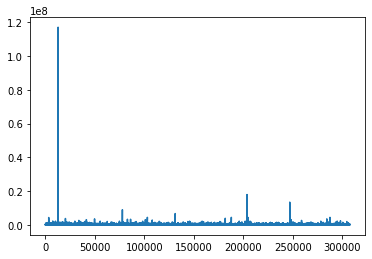

In [ ]:
df_group['AMT_INCOME_TOTAL'].plot()
df_group['AMT_INCOME'] = 0

In [ ]:
for i in range(len(df_group)):
    if df_group['AMT_INCOME_TOTAL'].iloc[i]<50000:
        df_group['AMT_INCOME'].iloc[i] = 'moins de 50 000 $'
    elif df_group['AMT_INCOME_TOTAL'].iloc[i]<100000:
        df_group['AMT_INCOME'].iloc[i] = 'entre 50 000 et 100 000 $'
    elif df_group['AMT_INCOME_TOTAL'].iloc[i]<150000:
        df_group['AMT_INCOME'].iloc[i] = 'entre 100 000 et 150 000 $'
    elif df_group['AMT_INCOME_TOTAL'].iloc[i]<200000:
        df_group['AMT_INCOME'].iloc[i] = 'entre 150 000 et 200 000 $'
    elif df_group['AMT_INCOME_TOTAL'].iloc[i]<250000:
        df_group['AMT_INCOME'].iloc[i] = 'entre 200 000 et 250 000 $'
    elif df_group['AMT_INCOME_TOTAL'].iloc[i]<300000:
        df_group['AMT_INCOME'].iloc[i] = 'entre 250 000 et 300 000 $'
    else:
        df_group['AMT_INCOME'].iloc[i] = 'plus de 300 000 $'


In [ ]:
income = df_group[['TARGET', 'AMT_INCOME', 'SK_ID_CURR']]
income.rename(columns={'SK_ID_CURR':'Identifiant'}, inplace=True)
income = income.merge(df_interp_sans_unite,
                      how='right', on='Identifiant').drop('Identifiant', axis=1)

In [ ]:
count = pd.DataFrame(data=income.groupby(['TARGET', 'AMT_INCOME']).count()['Durée emprunt'])
count.rename(columns={'Durée emprunt': 'Count'}, inplace=True)


In [ ]:
income = income.groupby(['TARGET', 'AMT_INCOME']).mean()
income = income.join(count)
income.reset_index(inplace=True)
percent(income, 'AMT_INCOME')
income

,TARGET,AMT_INCOME,Durée emprunt,Annuités,Âge,Début contrat travail,Annuités/revenus,Count,Percentage,Cible
0,0.00,entre 100 000 et 150 000 $,21.24,"23,896.23",40.18,6.52,19.23,67717,90.7 %,Pas d'impayés
1,0.00,entre 150 000 et 200 000 $,21.88,"28,639.61",40.65,6.72,16.92,50267,91.1 %,Pas d'impayés
2,0.00,entre 200 000 et 250 000 $,22.34,"32,852.44",41.09,6.82,14.99,39045,91.9 %,Pas d'impayés
3,0.00,entre 250 000 et 300 000 $,22.91,"36,294.10",41.57,7.10,13.26,14136,92.8 %,Pas d'impayés
4,0.00,entre 50 000 et 100 000 $,20.31,"18,685.29",40.11,6.36,23.03,37697,90.4 %,Pas d'impayés
5,0.00,moins de 50 000 $,19.12,"14,074.37",40.97,6.67,32.78,1794,90.5 %,Pas d'impayés
6,0.00,plus de 300 000 $,22.87,"42,916.18",41.93,7.16,11.08,19628,93.9 %,Pas d'impayés
7,1.00,entre 100 000 et 150 000 $,20.04,"24,343.71",37.62,4.79,19.64,6951,9.3 %,Impayés
8,1.00,entre 150 000 et 200 000 $,20.70,"28,595.47",38.29,4.94,16.94,4916,8.9 %,Impayés
9,1.00,entre 200 000 et 250 000 $,21.04,"31,566.96",39.53,5.22,14.46,3426,8.1 %,Impayés


In [ ]:
bar_plot(income, 'AMT_INCOME')

In [ ]:
income.to_csv(source_path + 'income', index=False)

### Statut marital

In [ ]:
df_group['NAME_FAMILY_STATUS'].unique()

['Single / not married', 'Married', 'Civil marriage', 'Widow', 'Separated', 'Unknown']
Categories (6, object): ['Single / not married', 'Married', 'Civil marriage', 'Widow', 'Separated', 'Unknown']

In [ ]:
family = df_group[['TARGET', 'NAME_FAMILY_STATUS', 'SK_ID_CURR']]
family.rename(columns={'SK_ID_CURR':'Identifiant'}, inplace=True)
family = family.merge(df_interp_sans_unite,
                    how='right', on='Identifiant').drop('Identifiant', axis=1)

In [ ]:
count = pd.DataFrame(data=family.groupby(['TARGET', 'NAME_FAMILY_STATUS']).count()['Durée emprunt'])
count.rename(columns={'Durée emprunt': 'Count'}, inplace=True)
count

Count
TARGET NAME_FAMILY_STATUS             
0.00   Civil marriage        23,460.00
       Married              150,715.00
       Separated             14,608.00
       Single / not married  35,194.00
       Unknown                     nan
       Widow                  6,307.00
1.00   Civil marriage         2,734.00
       Married               13,189.00
       Separated              1,392.00
       Single / not married   4,119.00
       Unknown                     nan
       Widow                    401.00

In [ ]:
family = family.groupby(['TARGET', 'NAME_FAMILY_STATUS']).mean()
family = family.join(count)
family.reset_index(inplace=True)
percent(family, 'NAME_FAMILY_STATUS')
family

,TARGET,NAME_FAMILY_STATUS,Durée emprunt,Annuités,Âge,Début contrat travail,Annuités/revenus,Count,Percentage,Cible
0,0.00,Civil marriage,21.20,"25,526.25",39.34,5.82,16.19,"23,460.00",89.6 %,Pas d'impayés
1,0.00,Married,22.01,"29,281.90",41.14,7.00,18.63,"150,715.00",92.0 %,Pas d'impayés
2,0.00,Separated,21.67,"25,708.70",43.46,6.93,15.66,"14,608.00",91.3 %,Pas d'impayés
3,0.00,Single / not married,20.22,"25,054.59",36.34,5.32,15.63,"35,194.00",89.5 %,Pas d'impayés
4,0.00,Unknown,nan,nan,nan,nan,nan,nan,nan %,Pas d'impayés
5,0.00,Widow,22.29,"24,763.04",51.98,9.34,16.35,"6,307.00",94.0 %,Pas d'impayés
6,1.00,Civil marriage,19.94,"25,014.60",37.95,4.45,16.92,"2,734.00",10.4 %,Impayés
7,1.00,Married,20.87,"28,090.31",38.89,5.31,19.34,"13,189.00",8.0 %,Impayés
8,1.00,Separated,20.67,"25,414.96",41.39,5.14,16.40,"1,392.00",8.7 %,Impayés
9,1.00,Single / not married,19.19,"24,777.69",34.56,3.98,16.70,"4,119.00",10.5 %,Impayés


In [ ]:
bar_plot(family, 'NAME_FAMILY_STATUS')

In [ ]:
family.to_csv(source_path + 'family', index=False)

### Bilan

In [ ]:
df_group = df_group[['SK_ID_CURR', 'CODE_GENDER', 'ORGANIZATION_TYPE',
                     'NAME_EDUCATION_TYPE', 'AMT_INCOME', 'NAME_FAMILY_STATUS']]
df_group.head()

,SK_ID_CURR,CODE_GENDER,ORGANIZATION_TYPE,NAME_EDUCATION_TYPE,AMT_INCOME,NAME_FAMILY_STATUS
0,100002,M,Entité commerciale,Secondary / secondary special,entre 200 000 et 250 000 $,Single / not married
1,100003,F,Education,Higher education,entre 250 000 et 300 000 $,Married
2,100004,M,Government,Secondary / secondary special,entre 50 000 et 100 000 $,Single / not married
3,100006,F,Entité commerciale,Secondary / secondary special,entre 100 000 et 150 000 $,Civil marriage
4,100007,M,Autre,Secondary / secondary special,entre 100 000 et 150 000 $,Single / not married


In [ ]:
df_group[df_group['SK_ID_CURR'] == 100005]['CODE_GENDER'].iloc[0]

'M'

# 2. Application

In [ ]:
identifiant = 100005

In [ ]:
# import des données 
df = pd.read_csv(source_path + 'data_api.csv')
# df.drop('Unnamed: 0', axis=1, inplace=True)

df_int = pd.read_csv(source_path + 'df_interprete')
df_int = df_int.drop('Unnamed: 0', axis=1)

df_int_sans_unite = pd.read_csv(source_path + 'df_interp_sans_unite')
# df_int_sans_unite.drop('Unnamed: 0', axis=1, inplace=True)

genre = pd.read_csv(source_path + 'genre')
income = pd.read_csv(source_path + 'income')
education_type = pd.read_csv(source_path + 'education_type')
organization_type = pd.read_csv(source_path + 'organization_type')



interpretable_important_data = ['SK_ID_CURR',
                                'PAYMENT_RATE',
                                'AMT_ANNUITY',
                                'DAYS_BIRTH',
                                'DAYS_EMPLOYED',
                                'ANNUITY_INCOME_PERC']

interpretable_important_data_target = ['SK_ID_CURR',
                                       'PAYMENT_RATE',
                                       'AMT_ANNUITY',
                                       'DAYS_BIRTH',
                                       'DAYS_EMPLOYED',
                                       'ANNUITY_INCOME_PERC',
                                       'TARGET']

In [ ]:
print(len(df['SK_ID_CURR']))
print(len(df_group['SK_ID_CURR']))

10000
291603


In [ ]:
df_group.to_csv(source_path + 'df_group', index=False)

In [ ]:
# import du modèle lgbm entrainé
infile = open(source_path + 'LightGBMModel.pkl', 'rb')
lgbm = load(infile)
infile.close()

# import du modèle NearestNeighbors entrainé sur le trainset
infile = open(source_path + 'NearestNeighborsModel.pkl', 'rb')
nn = load(infile)
infile.close()

# import du dataframe nettoyé pour le NearestNeighbors
infile = open(source_path + 'df_nn.pkl', 'rb')
df_nn = load(infile)
infile.close()

# import du Standard Scaler entrainé pour le NearestNeighbors
infile = open(source_path + 'StandardScaler.pkl', 'rb')
std = load(infile)
infile.close()

In [ ]:
df_client = df[df['SK_ID_CURR'] == identifiant]
df_client_int = df_int[df_int['Identifiant'] == identifiant]
df_client_int_SU = df_int_sans_unite[df_int_sans_unite['Identifiant'] == identifiant]
df_client_int.set_index('Identifiant', inplace=True)
# on affiche notre client
print('## Informations client')
df_client_int.drop('Défaut paiement', axis=1)

In [ ]:
df_client.shape

In [ ]:
feats = [f for f in df_client.columns if f not in ['SK_ID_CURR', 'TARGET']]
lgbm.predict_proba(df_client[feats])

In [ ]:
results = pd.DataFrame(lgbm.predict_proba(df_client[feats]), index=[identifiant])
    
results.rename({0: "Absence de défaut de paiement", 1: "Probabilité d'impayés"}, axis=1, inplace=True)
    
print("## Prédiction")
results

In [ ]:
proba = results["Probabilité d'impayés"].iloc[0]
def_p = "Défaut paiement : " + str(df_client_int['Défaut paiement'].iloc[0])
if proba < 0.5:
    print("Résultat : :white_check_mark: **Faible risque d'impayés** ")
    print(def_p)
else:
    print("Résultat : :warning: **Risque d'impayés important, client à surveiller** ")
    print('>', def_p)

In [ ]:
def radar_chart(client, param):
    """Fonction qui trace le graphe radar du client comparé aux crédits accordés/refusés
    pour un certain paramètre"""

    def _invert(x, limits):
        """inverts a value x on a scale from
        limits[0] to limits[1]"""
        return limits[1] - (x - limits[0])

    def _scale_data(data, ranges):
        """scales data[1:] to ranges[0],
        inverts if the scale is reversed"""
        for d, (y1, y2) in zip(data, ranges):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
            
        x1, x2 = ranges[0]
        d = data[0]
        
        if x1 > x2:
            d = _invert(d, (x1, x2))
            x1, x2 = x2, x1
            
        sdata = [d]
        
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            if y1 > y2:
                d = _invert(d, (y1, y2))
                y1, y2 = y2, y1
                
            sdata.append((d - y1) / (y2 - y1) * (x2 - x1) + x1)
            
        return sdata


    class ComplexRadar():
        def __init__(self, fig, variables, ranges,
                     n_ordinate_levels=6):
            angles = np.arange(0, 360, (360. / len(variables)))

            axes = [fig.add_axes([0.1, 0.1, 0.9, 0.9], polar=True,
                                 label="axes{}".format(i))
                    for i in range(len(variables))]

            axes[0].set_thetagrids(angles,labels=[])

            for ax in axes[1:]:
                ax.patch.set_visible(False)
                ax.grid("off")
                ax.xaxis.set_visible(False)
                
            for i, ax in enumerate(axes):
                grid = np.linspace(*ranges[i],
                                   num=n_ordinate_levels)
                gridlabel = ["{}".format(round(x, 2))
                             for x in grid]
                if ranges[i][0] > ranges[i][1]:
                    grid = grid[::-1]  # hack to invert grid
                    # gridlabels aren't reversed
                gridlabel[0] = ""  # clean up origin
                ax.set_rgrids(grid, labels=gridlabel,angle=angles[i])
                #ax.spines["polar"].set_visible(False)
                ax.set_ylim(*ranges[i])
                
            ticks = angles
            ax.set_xticks(np.deg2rad(ticks)) # crée les axes suivant les angles, en radians
            ticklabels = variables
            ax.set_xticklabels(ticklabels, fontsize=10) # définit les labels

            angles1 = np.linspace(0,2*np.pi,len(ax.get_xticklabels())+1)
            angles1[np.cos(angles1) < 0] = angles1[np.cos(angles1) < 0] + np.pi
            angles1 = np.rad2deg(angles1)
            labels = []
            for label, angle in zip(ax.get_xticklabels(), angles1):
                x,y = label.get_position()
                lab = ax.text(x,y-.45, # pour décaler les labels sur les axes
                              label.get_text(), transform=label.get_transform(),
                              ha=label.get_ha(), va=label.get_va())
                lab.set_rotation(angle)
                lab.set_fontsize(16)
                lab.set_fontweight('bold')
                labels.append(lab)
            ax.set_xticklabels([])              
                
            # variables for plotting
            self.angle = np.deg2rad(np.r_[angles, angles[0]])
            self.ranges = ranges
            self.ax = axes[0]

        def plot(self, data, *args, **kw):
            sdata = _scale_data(data, self.ranges)
            self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

        def fill(self, data, *args, **kw):
            sdata = _scale_data(data, self.ranges)
            self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def ok_impayes(df, var_name):
        cat = df_group[df_group['SK_ID_CURR'] == identifiant][var_name].iloc[0]
        ok = df[df[var_name] == cat][df['TARGET'] == 0]
        ok.drop(['TARGET', var_name], inplace=True, axis=1)
        impayes = df[df[var_name] == cat][df['TARGET'] == 1]
        impayes.drop(['TARGET', var_name], inplace=True, axis=1)
        return ok, impayes, cat
            
    if param == 'Genre':
        df = genre.copy()
        ok, impayes, cat = ok_impayes(df, 'CODE_GENDER')
        client = pd.concat([client, ok, impayes], ignore_index=True)
        
        
    if param == "Type d'entreprise":
        df = organization_type.copy()
        ok, impayes, cat = ok_impayes(df, 'ORGANIZATION_TYPE')
        client = pd.concat([client, ok, impayes], ignore_index=True)

    if param == "Niveau d'éducation":
        df = education_type.copy()
        ok, impayes, cat = ok_impayes(df, 'NAME_EDUCATION_TYPE')
        client = pd.concat([client, ok, impayes], ignore_index=True)
        
    if param == "Niveau de revenus":
        df = income.copy()
        ok, impayes, cat = ok_impayes(df, 'AMT_INCOME')
        client = pd.concat([client, ok, impayes], ignore_index=True)
        
    
    # data
    variables = ("Durée emprunt", "Annuités", "Âge",
                 "Début contrat travail", "Annuités/revenus")
    data_ex = client.iloc[0]
    ranges = [(min(client["Durée emprunt"])-1, max(client["Durée emprunt"])+1),
              (min(client["Annuités"])-100, max(client["Annuités"])+100),
              (min(client["Âge"])-5, max(client["Âge"])+5),
              (min(client["Début contrat travail"])-1, max(client["Début contrat travail"])+1),
              (min(client["Annuités/revenus"])-5, max(client["Annuités/revenus"])+5)]
    # plotting
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, ranges)
    radar.plot(data_ex, label='Notre client')
    radar.fill(data_ex, alpha=0.2)    
        
    radar.plot(ok.iloc[0],
               label='Moyenne des clients similaires sans défaut de paiement',
               color='g')
    radar.plot(impayes.iloc[0],
               label='Moyenne des clients similaires avec défaut de paiement',
               color='r')
    
    fig1.legend(bbox_to_anchor=(1.7,1))
        
    plt.show()

In [ ]:
# création du graphe radar 
radar_chart(df_client_int_SU.drop('Identifiant', axis=1), param='Niveau de revenus')